<a href="https://colab.research.google.com/github/shaked-fried/Interactive_AI_PickMeUP/blob/main/assumptions_checking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import re
import numpy as np
import seaborn as sns
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report,confusion_matrix




In [ ]:
# !pip install ipython-autotime

In [ ]:
# %load_ext autotime

In [ ]:

# For Google Colab

# #---------------------------------

from google.colab import drive
drive.mount("/content/gdrive", force_remount=False)
# Shaked path
%cd /content/gdrive/MyDrive/DataScience/Curtains/three_seasons/
# %ls


Mounted at /content/gdrive
/content/gdrive/MyDrive/DataScience/Curtains/three_seasons


In [ ]:
# %cd /content/gdrive/MyDrive/DataScience/Curtains/three_seasons/
# %ls
# proccessed_df = pd.read_csv('proccessed_OCTOBER.csv')
proccessed_df = pd.read_csv('proccessed_4_months_ALL_FLOORS_NUM.csv')
# , dtype='StartedOn')

In [ ]:
proccessed_df

,StartedOn,Value,face,week,Date,Hour,curtain,azimuth,min_range,max_range,f_hour,auto_sched,floor
0,3/7/2022 3:00:00,0.0,A,26,3.7.2022,3:00:00,1,200,110,290,3.000,0,25
1,3/7/2022 3:10:00,0.0,A,26,3.7.2022,3:10:00,1,200,110,290,3.167,0,25
2,3/7/2022 3:20:00,0.0,A,26,3.7.2022,3:20:00,1,200,110,290,3.333,0,25
3,3/7/2022 3:30:00,0.0,A,26,3.7.2022,3:30:00,1,200,110,290,3.500,0,25
4,3/7/2022 3:40:00,0.0,A,26,3.7.2022,3:40:00,1,200,110,290,3.667,0,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4810727,16/1/2022 12:10:00,0.0,N,2,16.1.2022,12:10:00,24,285,195,15,12.167,0,27
4810728,16/1/2022 12:20:00,0.0,N,2,16.1.2022,12:20:00,24,285,195,15,12.333,0,27
4810729,16/1/2022 12:30:00,0.0,N,2,16.1.2022,12:30:00,24,285,195,15,12.500,0,27
4810730,16/1/2022 12:40:00,1.0,N,2,16.1.2022,12:40:00,24,285,195,15,12.667,0,27


In [ ]:
# author: Shaked Fried
# date: 25/4/23

import numpy as np
import seaborn as sns
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

#---------------------------------
# Load data
#---------------------------------


proccessed_df = pd.read_csv('proccessed_4_months_ALL_FLOORS_NUM.csv')



#---------------------------------
# Process and Finalized auto_sched
#---------------------------------

#function dedicated to fix problematic "not really manual" behaviour:
#sometimes its seems like auto schedual and curtain
#are not synchronizes although there is only a shift of 10-20 min
#in that case we will point out values that consist a change and not synchronized status and check whether
# there was a change in the autoschedual latly

def fix_shifted_auto_sched(DF):
  DF = DF.sort_values(by=['floor','face','curtain','Date','Hour'])
  DF['change_in_auto_sign'] = DF['auto_sched'].diff() #change in auto schedual status
  DF['change_in_auto'] = np.abs(DF['auto_sched'].diff()) #change in auto schedual status -absolute-
  DF['suspiciuose'] = np.where(np.abs(DF['Value']-DF['auto_sched'])==1,1,0)
  DF['rolling_change'] = DF.change_in_auto.rolling(3,center=True).max()
  DF['suspiciuose_plus_rolling'] = DF['suspiciuose'] + DF['rolling_change']
  DF['finalized_auto_sched'] = np.where(DF['suspiciuose_plus_rolling']==2, (1-DF['auto_sched']),DF['auto_sched'] )
  DF['Manual_intervension'] = (DF['Value']-DF['finalized_auto_sched'])
  DF['Manual_intervension_change'] = DF['Manual_intervension'].diff()
  # DF['Manual_intervension_start'] = np.where(DF['Manual_intervension_change']>0,1,0) #if we care only about opening interventions
  DF['Manual_intervension_start'] = np.where(DF['Manual_intervension_change']==0,0,1) #exdact time should be fixed!!

  ## LOGS:
  # print("LOG\n NO. of suspiciuose values (Value != auto_sched) is: ",DF['suspiciuose'][DF['suspiciuose']==1].count() ,"\n NO. of updates values in finalized_auto_sched is:   ",DF['suspiciuose_plus_rolling'][DF['suspiciuose_plus_rolling']==2].count()) # LOG
  # # print("change_in_status",DF['change_in_status'].unique())
  # print(" suspiciuose",DF['suspiciuose'].unique(),"DF['rolling_change']",DF['rolling_change'].unique())
  # print("DF['suspiciuose_plus_rolling']",DF['suspiciuose_plus_rolling'].unique())
  
  DF = DF.drop(columns=['rolling_change','suspiciuose','suspiciuose_plus_rolling','Manual_intervension_change'])
              #  ,'change_in_auto'])

  return DF


#-------------------------------------
#  remove records out of working time  
#-------------------------------------

# records kept for:
# Hours 06:00 > h > 22:00 
# WeekDays sunday to thursday 
def to_day(x):
  """
  given a string that describes time converting it to datetime 
  """
  # print(x)
  # print(type(x))
  # return datetime.strptime(x, "%d/%m/%Y %H:%M")
  
  try:
    return datetime.strptime(x, "%d/%m/%Y %H:%M")
  except:
    return datetime.strptime(x, "%d/%m/%Y %H:%M:%S")
  
def extracet_working_time(df):
  df['daytime']= df['StartedOn'].apply(lambda row: to_day(row)) #add daytime for datetime
  df['day'] = df['daytime'].dt.dayofweek #2 for monday
  df = df[(df['day']!=4)& (df['day']!=5)]
  df =df[(df['f_hour']>6) & (df['f_hour']<22)]
  return df



#-----------------------
#  create complex 4 code  
#-----------------------

# -10 closed (manually)
# -4 closed (Auto)  

# 4 open (Auto)
# 10 opened (manually) 


def complex_4_code(DF):
  code = 0
  if DF['Manual_intervension']==0:
    code=4
    if DF['finalized_auto_sched']==1:
      code = code*(-1)
  else:
    code=10
    if DF['finalized_auto_sched']==0:
      code = code*(-1)

  return code


#-----------------------
#  plot
#-----------------------

# def plot_hist(df):

#   b = df.pivot(index='StartedOn', columns='Cluster and Azimuth', values='code')
#   #b = b.reindex(['14 {0}','15 {0}', '16 {0}','17 {0}','18 {0, 359}','49 {0, 10}','13 {10}','12 {22}','44 {22}','45 {300, 22}','11 {305, 300, 22}','34 {110}','35 {110}','36 {110}','37 {110}','38 {110}','39 {110}','40 {110}','41 {130, 110}','20 {200, 130}','42 {200, 210, 130}','0 {200}','21 {200}','23 {200}','24 {200}','25 {200}','26 {200}','27 {200}','28 {200}','29 {200}','30 {200}','31 {200}','32 {200}','33 {200}','43 {200}','1 {200, 285}','46 {200, 285}','19 {130, 359}','48 {130, 359}','2 {285}','3 {285}','4 {285}','47 {285}','5 {305, 285}','10 {305}','6 {305}','7 {305}','8 {305}','9 {305}'], axis=1)
#   b = b.reindex(s, axis=1)
#   df = b
#   fig, ax = plt.subplots(figsize=(49,49))
#   sns.heatmap(df, cmap='coolwarm', cbar=False)
#   date_str = f['date'].iloc[0].replace('/','-')
#   print(date_str)
#   plt.savefig('october_27_v10'+'_'+str(date_str)+'.png',dpi=100)
#   plt.show()



#---------------------------------
#  Time between opening to closing
#---------------------------------

def shift_add(df, n):

# Calculate sum of corresponding values in 'change_in_auto' and 'manual_intervention' columns for different shift values
# n*10 is Maximum shift value in min

  delta_between_auto_cange_to_manual_change = pd.DataFrame()
  for i in range(1, n+1):
      result_col_name = f'{i}_min_since_auto'
      df[result_col_name] = df['change_in_auto'] + df['Manual_intervension_start'].shift(i).fillna(0)
      display(df[result_col_name].value_counts().fillna(0).loc[2])
      delta_between_auto_cange_to_manual_change.at[0,result_col_name] = df[result_col_name].value_counts().fillna(0).loc[2]
  histo = delta_between_auto_cange_to_manual_change

  return df, histo




In [ ]:
fixed_proccessed_df = fix_shifted_auto_sched(proccessed_df)
fixed_proccessed_df['code'] = fixed_proccessed_df.apply(complex_4_code, axis =1)
fixed_proccessed_df = extracet_working_time(fixed_proccessed_df)
display(fixed_proccessed_df)

new_df,histo  = shift_add(fixed_proccessed_df,5)
ax = histo.plot.bar()



In [ ]:
# fixed_proccessed_df.to_csv('fixed_proccessed_df_of_4_months_ALL_FLOORS_NUM.csv')


In [ ]:
# fixed_proccessed_df = pd.read_csv('fixed_proccessed_df_of_4_months_ALL_FLOORS_NUM.csv')

# Grouping windows - not relevent

## Grouping windows by company's groups


In [ ]:
# origin = fixed_proccessed_df
# new_list = []
# grouped = pd.read_excel('27_grouped_from_company.xlsx')
# grouped = grouped.drop_duplicates(subset=['curtain_number'])
# grouped = grouped['curtain_number']

## Transforming the raw 'grouped' file and splitting by face and curtain

In [ ]:
# for index,i in enumerate(grouped):
#     string_row = i.split(',')
#     for j in string_row:
#         face = j[0]
#         curtains_bottom = int(j[1:].split('-')[0])
#         curtains_top = int(j[1:].split('-')[1])
#         curtains = [item for item in range(curtains_bottom, curtains_top+1)]
#         for curtain in curtains:
#             new_list.append([face,curtain,index])
# new_df = pd.DataFrame(new_list, columns = ['face', 'curtain','index'])

In [ ]:
# #Merging the groped curtains with our montly curtains movement data
# df_joined = pd.merge(origin, new_df, how='inner',on=['face','curtain'])
# df_joined = df_joined.dropna()

# # renaming for clarity
# df_joined.rename(columns = {'index' : 'cluster'}, inplace=True)

# # sorting the data by cluster for plot part - Dont think its really necessery
# df_joined.sort_values(by=['cluster'])

# # apply transformation
# df_joined_reduced_2 = df_joined
# df_joined_reduced_2['azimuth'] = df_joined_reduced_2['azimuth'].apply(lambda x: x%360)
# d = df_joined_reduced_2.groupby(['cluster','StartedOn'])['azimuth'].agg([set,lambda x: x.unique().mean()])
# a = df_joined_reduced_2.groupby(['cluster','StartedOn'])['code'].agg(lambda x:x.value_counts().index[0]).reset_index()

# g = a.merge(d, left_on=['cluster','StartedOn'], right_on=['cluster','StartedOn'])
# g = g.rename(columns={"<lambda_0>": "mean azimuth"})
# g = g.astype({'mean azimuth': str})
# c = g

# c['cluster'] = c['cluster'].apply(str)
# c['azimuth'] = c['set'].apply(str)
# c['Cluster and Azimuth'] = c[['cluster', 'azimuth']].apply(lambda x: ' '.join(x), axis=1)
# c['Mean Azimuth and Cluster'] = c[['mean azimuth', 'cluster']].apply(lambda x: ' '.join(x), axis=1)
# c['Mean Azimuth and Cluster']
# # c.sample(10)

# c['date'] = c['StartedOn'].apply(lambda x: x.split(' ')[0]) 
# c['StartedOn'] = pd.to_datetime(c['StartedOn'])
# type(c['StartedOn'][0])
# #c['date'] = c['StartedOn'].apply(lambda x: x.date()) # make date
# dfs = [c[c['date'] == date] for date in c['date'].unique()] # group by date
# s = list(set(dfs[0].sort_values(by=['mean azimuth'])['Cluster and Azimuth']))
# s.sort(key = lambda x: int(x.split()[1][1:-1]))

In [ ]:
# b = c.pivot(index='StartedOn', columns='Cluster and Azimuth', values='code')
# b = b.reindex(df_pivot['code'].sort_values(by=2012, ascending=False).index)
# b
# b = dfs[0].pivot(index='StartedOn', columns='Cluster and Azimuth', values='code')
# print(b)

## Plot part

In [ ]:
# for f in dfs:
#     plot_hist(f)

#features engineering

solar radiation

front

In [ ]:
# %cd /content/gdrive/MyDrive/DataScience/Curtains/
# # %ls

In [ ]:
solar = pd.read_csv("solar_info_july2july_21_22.csv")
print(len(solar))
# full_df = pd.read_csv("October_full_dt.csv")
solar['log_SolarRadAvg'] = round(np.log10(solar['SolarRadAvg (W/m^2)']+1),2)
solar['Time']= pd.to_datetime(solar['Time'],errors='coerce', format = "%m/%d/%Y %H:%M")
solar = solar.drop(labels=["SolarRadAvg (W/m^2)"],axis=1)

# print(type(solar['Time'][100]))
solar

114297


,Time,log_SolarRadAvg
0,2021-01-07 00:05:00,0.00
1,2021-01-07 00:10:00,0.00
2,2021-01-07 00:15:00,0.00
3,2021-01-07 00:20:00,0.00
4,2021-01-07 00:25:00,0.00
...,...,...
114292,NaT,0.10
114293,NaT,0.24
114294,NaT,0.25
114295,NaT,0.25


In [ ]:
solar['log_SolarRadAvg'].isna()['Time'].value_counts()

KeyError: ignored

In [ ]:
# fixed_proccessed_df['StartedOn']= pd.to_datetime(fixed_proccessed_df['StartedOn'])
print(type(fixed_proccessed_df['StartedOn'].iloc[0]))
fixed_proccessed_df['StartedOn']= pd.to_datetime(fixed_proccessed_df['StartedOn'])

<class 'str'>


In [ ]:
print(fixed_proccessed_df['Manual_intervension'].value_counts())

 0.00    2090823
-1.00      85000
 1.00      68535
-0.40       4231
-0.50       3994
          ...   
 0.41         13
 0.25          8
 0.17          5
 0.21          5
 0.29          4
Name: Manual_intervension, Length: 201, dtype: int64


In [ ]:
fixed_proccessed_df['Manual_int_target'].value_counts()

KeyError: ignored

In [ ]:
# DF = fixed_proccessed_df.join(solar.set_index('Time'), on='StartedOn')
# DF = DF[DF['log_SolarRadAvg'].notna()]
DF = pd.merge(fixed_proccessed_df,solar,left_on=['StartedOn'], right_on=['Time'],how='outer')

In [ ]:
display(DF[DF['log_SolarRadAvg'].isna()]['Date'].value_counts())

10.7.2022     57475
14.7.2022     57475
6.7.2022      57475
5.7.2022      57475
4.7.2022      57475
3.7.2022      57475
17.7.2022     57475
17.10.2021    57475
11.7.2022     57475
7.7.2022      57475
14.10.2021    57475
13.7.2022     57475
13.10.2021    57475
13.1.2022     57475
12.7.2022     57475
15.3.2022     39995
14.3.2022     39995
16.3.2022     39995
17.3.2022     39995
20.3.2022     39995
13.3.2022     39995
16.1.2022     24805
7.10.2021       605
Name: Date, dtype: int64

In [ ]:
DF.drop(columns = ['min_range','max_range','daytime','auto_sched'])

,StartedOn,Value,face,week,Date,Hour,curtain,azimuth,f_hour,floor,change_in_auto_sign,finalized_auto_sched,Manual_intervension,Manual_intervension_start,code,day,Time,log_SolarRadAvg
0,2022-10-01 10:00:00,1.0,A,2.0,10.1.2022,10:00:00,1.0,200.0,10.0,25.0,1.0,1.0,0.0,0.0,-4.0,0.0,2022-10-01 10:00:00,2.65
1,2022-10-01 10:00:00,1.0,A,2.0,10.1.2022,10:00:00,2.0,200.0,10.0,25.0,1.0,1.0,0.0,0.0,-4.0,0.0,2022-10-01 10:00:00,2.65
2,2022-10-01 10:00:00,1.0,A,2.0,10.1.2022,10:00:00,4.0,200.0,10.0,25.0,1.0,1.0,0.0,0.0,-4.0,0.0,2022-10-01 10:00:00,2.65
3,2022-10-01 10:00:00,0.0,A,2.0,10.1.2022,10:00:00,5.0,200.0,10.0,25.0,1.0,0.0,0.0,0.0,4.0,0.0,2022-10-01 10:00:00,2.65
4,2022-10-01 10:00:00,1.0,A,2.0,10.1.2022,10:00:00,6.0,200.0,10.0,25.0,1.0,1.0,0.0,0.0,-4.0,0.0,2022-10-01 10:00:00,2.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2416153,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-07 23:40:00,0.00
2416154,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-07 23:45:00,0.00
2416155,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-07 23:50:00,0.00
2416156,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-07 23:55:00,0.00


In [ ]:
DF.drop(columns = ['min_range','max_range','daytime','auto_sched'])[DF['log_SolarRadAvg'].isna()]

,StartedOn,Value,face,week,Date,Hour,curtain,azimuth,f_hour,floor,change_in_auto_sign,finalized_auto_sched,Manual_intervension,Manual_intervension_start,code,day,Time,log_SolarRadAvg
154945,2022-10-07 10:00:00,0.0,A,27.0,10.7.2022,10:00:00,1.0,200.0,10.000,25.0,0.0,0.0,0.0,0.0,4.0,6.0,NaT,NaN
154946,2022-10-07 10:00:00,0.0,A,27.0,10.7.2022,10:00:00,2.0,200.0,10.000,25.0,0.0,0.0,0.0,0.0,4.0,6.0,NaT,NaN
154947,2022-10-07 10:00:00,0.0,A,27.0,10.7.2022,10:00:00,4.0,200.0,10.000,25.0,0.0,0.0,0.0,0.0,4.0,6.0,NaT,NaN
154948,2022-10-07 10:00:00,0.0,A,27.0,10.7.2022,10:00:00,5.0,200.0,10.000,25.0,0.0,0.0,0.0,0.0,4.0,6.0,NaT,NaN
154949,2022-10-07 10:00:00,0.0,A,27.0,10.7.2022,10:00:00,6.0,200.0,10.000,25.0,0.0,0.0,0.0,0.0,4.0,6.0,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2166480,2022-07-07 09:50:00,0.0,N,27.0,7.7.2022,9:50:00,20.0,285.0,9.833,27.0,0.0,0.0,0.0,0.0,4.0,3.0,NaT,NaN
2166481,2022-07-07 09:50:00,0.0,N,27.0,7.7.2022,9:50:00,21.0,285.0,9.833,27.0,0.0,0.0,0.0,0.0,4.0,3.0,NaT,NaN
2166482,2022-07-07 09:50:00,0.0,N,27.0,7.7.2022,9:50:00,22.0,285.0,9.833,27.0,0.0,0.0,0.0,0.0,4.0,3.0,NaT,NaN
2166483,2022-07-07 09:50:00,0.0,N,27.0,7.7.2022,9:50:00,23.0,285.0,9.833,27.0,0.0,0.0,0.0,0.0,4.0,3.0,NaT,NaN


In [ ]:
DF['log_SolarRadAvg'].value_counts()
DF['log_SolarRadAvg'].isna().sum()

1127505

In [ ]:
DF_rad = DF
# DF_rad.sort_values(by=['StartedOn'])
DF_rad['Manual_int_target'] = np.where(DF_rad['Manual_intervension']==0,0,1)
DF_rad['var_rad'] = DF_rad['log_SolarRadAvg'].rolling(4, min_periods=1, center=False, closed = 'left').var()
DF_rad['rad*azimuth'] = ((np.cos(DF_rad['azimuth'])*(-1))+1)*DF_rad['log_SolarRadAvg']
DF_rad['sum_rad*azimuth'] = DF_rad['rad*azimuth'].rolling(4, min_periods=1, center=False, closed = 'left').sum()
DF_rad['season'] = DF_rad['daytime'].dt.month%12 //3 + 1 # 1-winter, 2-spring, 3-summer, 4-fall
DF_rad = pd.get_dummies(DF_rad, columns = ['day'])


# DF_rad['rad*asimuth_diff'] = DF_rad['rad*asimuth'].diff()

In [ ]:
DF_rad.columns

Index(['StartedOn', 'Value', 'face', 'week', 'Date', 'Hour', 'curtain',
       'azimuth', 'min_range', 'max_range', 'f_hour', 'auto_sched', 'floor',
       'change_in_auto_sign', 'finalized_auto_sched', 'Manual_intervension',
       'Manual_intervension_start', 'code', 'daytime', 'Time',
       'log_SolarRadAvg', 'Manual_int_target', 'var_rad', 'rad*azimuth',
       'sum_rad*azimuth', 'season', 'day_0.0', 'day_1.0', 'day_2.0', 'day_3.0',
       'day_6.0'],
      dtype='object')

## Exploration 

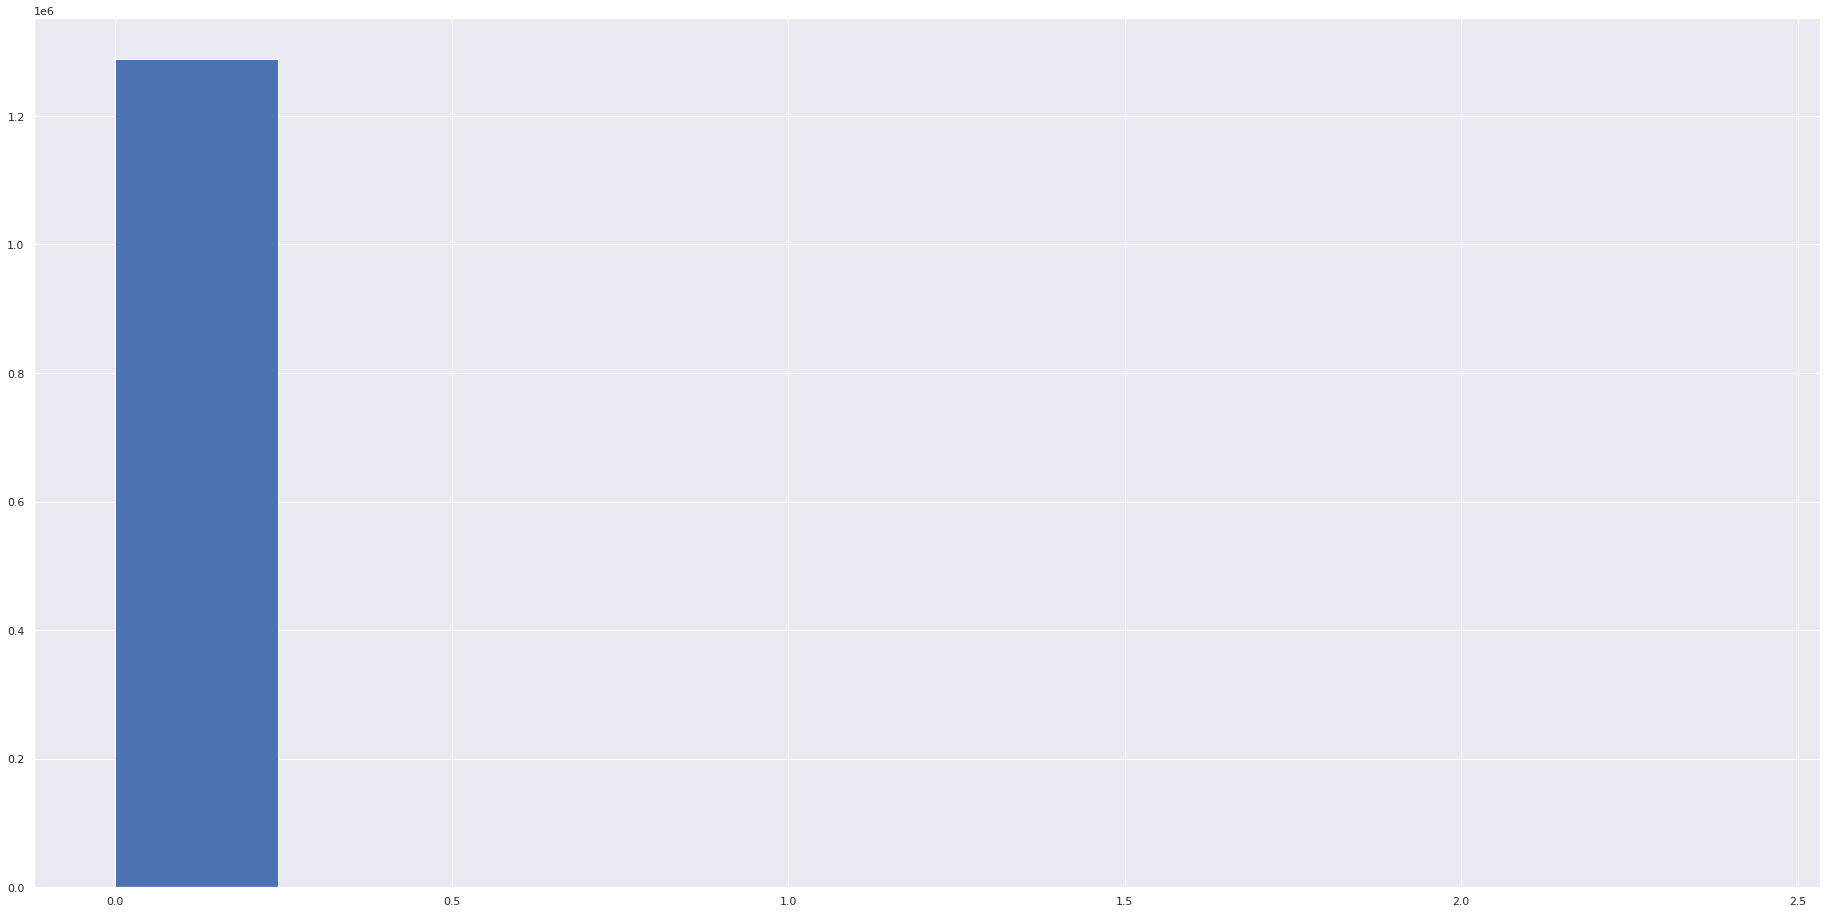

In [ ]:
DF_rad1 = DF_rad.drop(columns=['min_range','max_range','code','auto_sched','curtain','finalized_auto_sched','Value','change_in_auto_sign','Manual_intervension_start'])
# for feat in DF_rad.columns:
# DF_rad1['Manual_intervension'].hist()
# DF_rad1["Manual_intervension"].plot(kind="hist", logy=True)
# DF_rad1['Manual_int_target'].hist()
DF_rad1['var_rad'].hist()
# DF_rad1['sum_rad*azimuth'].hist()

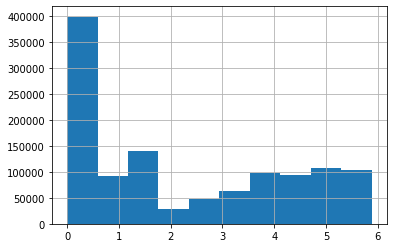

In [ ]:

DF_rad1['rad*azimuth'].hist()

In [ ]:
DF_rad1

,StartedOn,face,week,Date,Hour,azimuth,f_hour,floor,Manual_intervension,daytime,...,Manual_int_target,var_rad,rad*azimuth,sum_rad*azimuth,season,day_0.0,day_1.0,day_2.0,day_3.0,day_6.0
0,2022-10-01 10:00:00,A,2.0,10.1.2022,10:00:00,200.0,10.0,25.0,0.0,2022-01-10 10:00:00,...,0,NaN,1.358953,NaN,1.0,1,0,0,0,0
1,2022-10-01 10:00:00,A,2.0,10.1.2022,10:00:00,200.0,10.0,25.0,0.0,2022-01-10 10:00:00,...,0,NaN,1.358953,1.358953,1.0,1,0,0,0,0
2,2022-10-01 10:00:00,A,2.0,10.1.2022,10:00:00,200.0,10.0,25.0,0.0,2022-01-10 10:00:00,...,0,0.000000e+00,1.358953,2.717905,1.0,1,0,0,0,0
3,2022-10-01 10:00:00,A,2.0,10.1.2022,10:00:00,200.0,10.0,25.0,0.0,2022-01-10 10:00:00,...,0,0.000000e+00,1.358953,4.076858,1.0,1,0,0,0,0
4,2022-10-01 10:00:00,A,2.0,10.1.2022,10:00:00,200.0,10.0,25.0,0.0,2022-01-10 10:00:00,...,0,0.000000e+00,1.358953,5.435811,1.0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2416153,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,...,1,-3.863842e-13,NaN,NaN,NaN,0,0,0,0,0
2416154,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,...,1,-3.863842e-13,NaN,NaN,NaN,0,0,0,0,0
2416155,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,...,1,-3.863842e-13,NaN,NaN,NaN,0,0,0,0,0
2416156,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,...,1,-3.863842e-13,NaN,NaN,NaN,0,0,0,0,0


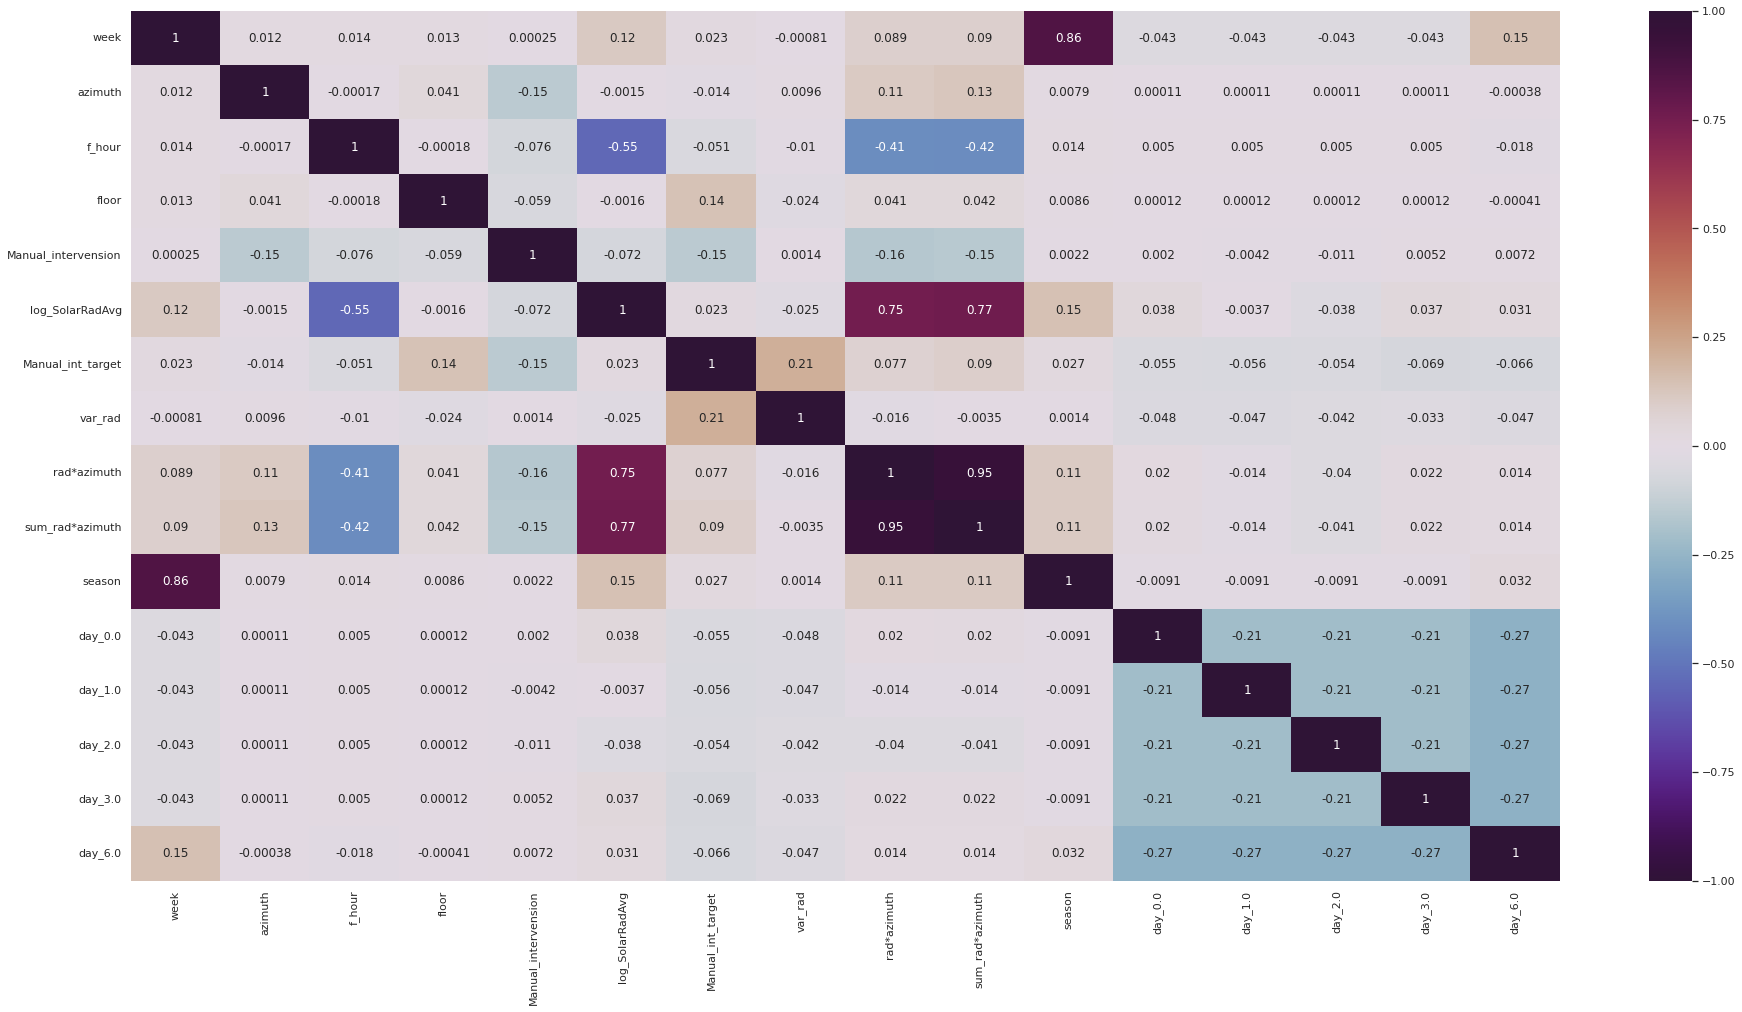

In [ ]:
DF_rolling_corr = DF_rad1.corr()
sns.set(rc = {'figure.figsize':(32,16)})
sns.heatmap(DF_rolling_corr, annot = True,cmap='twilight_shifted',vmin=-1, vmax=1)

In [ ]:
DF_sum_rad5 = DF_rad1[DF_rad1['Manual_intervension']<=0]

In [ ]:
DF_sum_rad5

,StartedOn,face,week,Date,Hour,azimuth,f_hour,floor,Manual_intervension,daytime,...,Manual_int_target,var_rad,rad*azimuth,sum_rad*azimuth,season,day_0.0,day_1.0,day_2.0,day_3.0,day_6.0
0,2022-10-01 10:00:00,A,2.0,10.1.2022,10:00:00,200.0,10.000,25.0,0.0,2022-01-10 10:00:00,...,0,NaN,1.358953,NaN,1.0,1,0,0,0,0
1,2022-10-01 10:00:00,A,2.0,10.1.2022,10:00:00,200.0,10.000,25.0,0.0,2022-01-10 10:00:00,...,0,NaN,1.358953,1.358953,1.0,1,0,0,0,0
2,2022-10-01 10:00:00,A,2.0,10.1.2022,10:00:00,200.0,10.000,25.0,0.0,2022-01-10 10:00:00,...,0,0.000000e+00,1.358953,2.717905,1.0,1,0,0,0,0
3,2022-10-01 10:00:00,A,2.0,10.1.2022,10:00:00,200.0,10.000,25.0,0.0,2022-01-10 10:00:00,...,0,0.000000e+00,1.358953,4.076858,1.0,1,0,0,0,0
4,2022-10-01 10:00:00,A,2.0,10.1.2022,10:00:00,200.0,10.000,25.0,0.0,2022-01-10 10:00:00,...,0,0.000000e+00,1.358953,5.435811,1.0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2303945,2022-09-03 09:50:00,N,10.0,9.3.2022,9:50:00,285.0,9.833,27.0,0.0,2022-03-09 09:50:00,...,0,-5.998096e-15,4.393691,17.574766,2.0,0,0,1,0,0
2303946,2022-09-03 09:50:00,N,10.0,9.3.2022,9:50:00,285.0,9.833,27.0,0.0,2022-03-09 09:50:00,...,0,-5.998096e-15,4.393691,17.574766,2.0,0,0,1,0,0
2303947,2022-09-03 09:50:00,N,10.0,9.3.2022,9:50:00,285.0,9.833,27.0,0.0,2022-03-09 09:50:00,...,0,-5.998096e-15,4.393691,17.574766,2.0,0,0,1,0,0
2303948,2022-09-03 09:50:00,N,10.0,9.3.2022,9:50:00,285.0,9.833,27.0,0.0,2022-03-09 09:50:00,...,0,-5.998096e-15,4.393691,17.574766,2.0,0,0,1,0,0


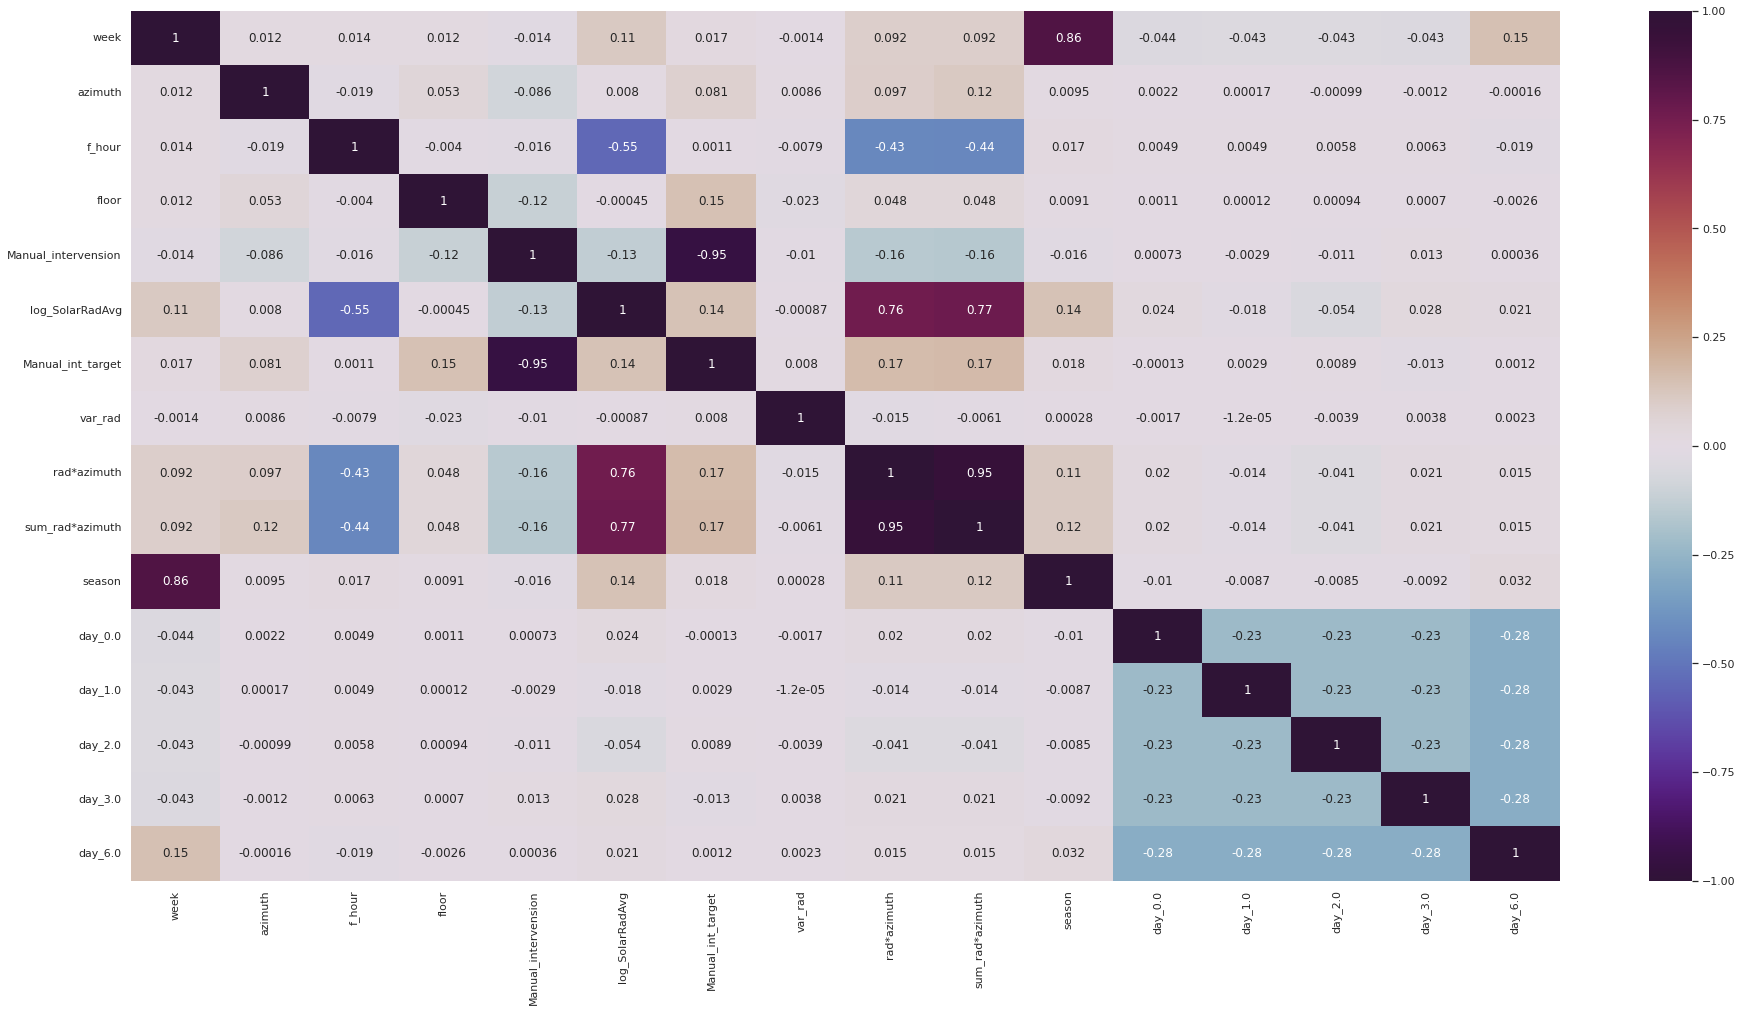

In [ ]:
DF_rolling_corr = DF_sum_rad5.corr()
sns.set(rc = {'figure.figsize':(32,16)})
sns.heatmap(DF_rolling_corr, annot = True,cmap='twilight_shifted',vmin=-1, vmax=1)

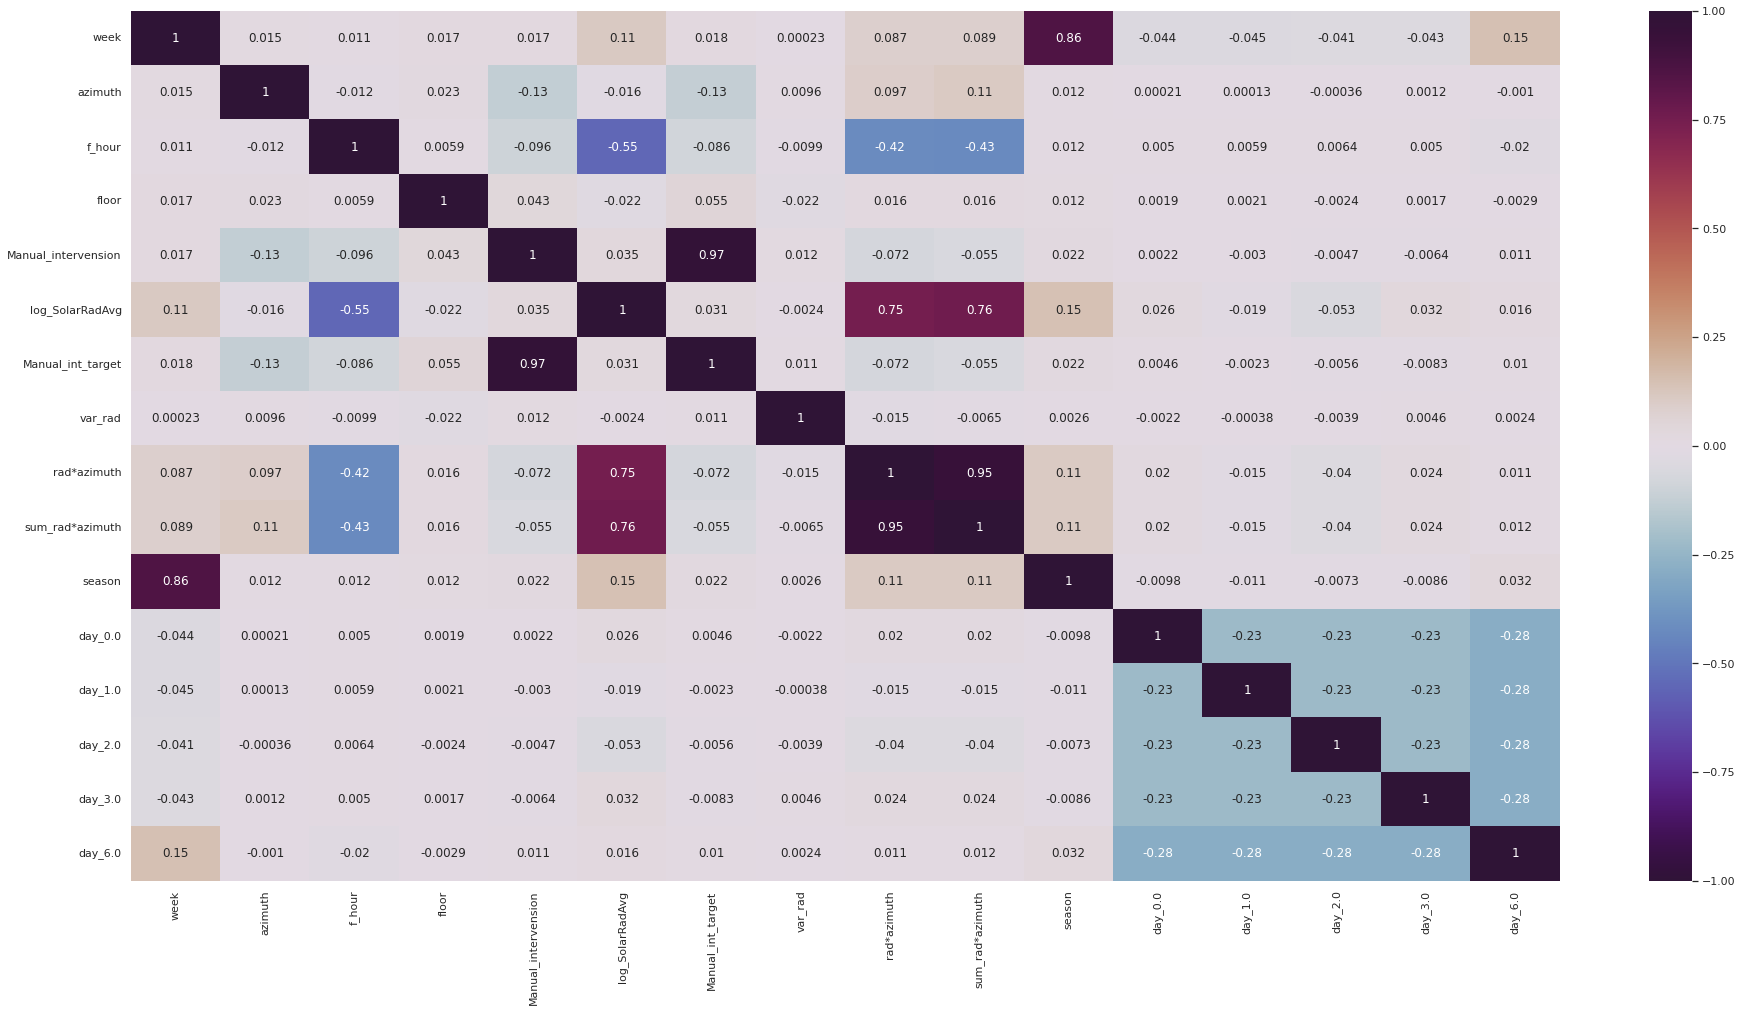

In [ ]:
DF_sum_rad6 = DF_rad1[DF_rad1['Manual_intervension']>=0]
DF_rolling_corr = DF_sum_rad6.corr()
sns.set(rc = {'figure.figsize':(32,16)})
sns.heatmap(DF_rolling_corr, annot = True,cmap='twilight_shifted',vmin=-1, vmax=1)


# print(len(DF_sum_rad6))

# XGboost

---



In [ ]:
# import xgboost as xgb
# # split data into X and y
# Y = DF_rad1['Manual_intervension']
# X = DF_rad1[['log_SolarRadAvg','var_rad','sum_rad*azimuth','day','f_hour','week']]

# # split data into train and test sets,
# seed = 7
# test_size = 0.33
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)



# # specify parameters via map
# param = {'max_depth':2, 'eta':1, 'objective':'binary:logistic' }
# num_round = 2
# bst = xgb.train(param, dtrain, num_round)
# # make prediction
# preds = bst.predict(dtest)

In [ ]:
DF_sum_rad5['Manual_int_target'].value_counts()

0    2090823
1     128268
Name: Manual_int_target, dtype: int64

In [ ]:
# from sklearn.metrics import f1_score
# import numpy as np

# def f1_eval(y_pred, dtrain):
#     y_true = dtrain.get_label()
#     err = 1-f1_score(y_true, np.round(y_pred))
#     return 'f1_err', err

In [ ]:
# split data into X and y
Y = DF_sum_rad5['Manual_int_target']
X = DF_sum_rad5[['f_hour','week','var_rad','season','azimuth','sum_rad*azimuth','day_0.0','day_1.0','day_2.0','day_3.0','day_6.0','floor']]
display(X.columns)

# # split data into train and test sets
seed = 7
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)


#Uriel - ratio of classes
from collections import Counter
counter = Counter(y_train)
# estimate scale_pos_weight value
class_ratio = counter[0] / counter[1]
print(class_ratio)

# fit model no training data
# xgb.set_config(verbosity=2)
model = XGBClassifier(scale_pos_weight=class_ratio, max_depth=6, verbose = 2)
eval_s = [(X_train, y_train), (X_test, y_test)]
evals_result = {}
model.fit(X_train, y_train)#, eval_metric = f1_eval)


Index(['f_hour', 'week', 'var_rad', 'season', 'azimuth', 'sum_rad*azimuth',
       'day_0.0', 'day_1.0', 'day_2.0', 'day_3.0', 'day_6.0', 'floor'],
      dtype='object')

16.246869322763352


XGBClassifier(max_depth=6, scale_pos_weight=16.246869322763352, verbose=2)

In [ ]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

# make predictions for train data


print(type(X))

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

<class 'pandas.core.frame.DataFrame'>
Accuracy: 85.92%
[[357273  61211]
 [  1264  24071]]
              precision    recall  f1-score   support

           0       1.00      0.85      0.92    418484
           1       0.28      0.95      0.44     25335

    accuracy                           0.86    443819
   macro avg       0.64      0.90      0.68    443819
weighted avg       0.96      0.86      0.89    443819



pandas.core.frame.DataFrame

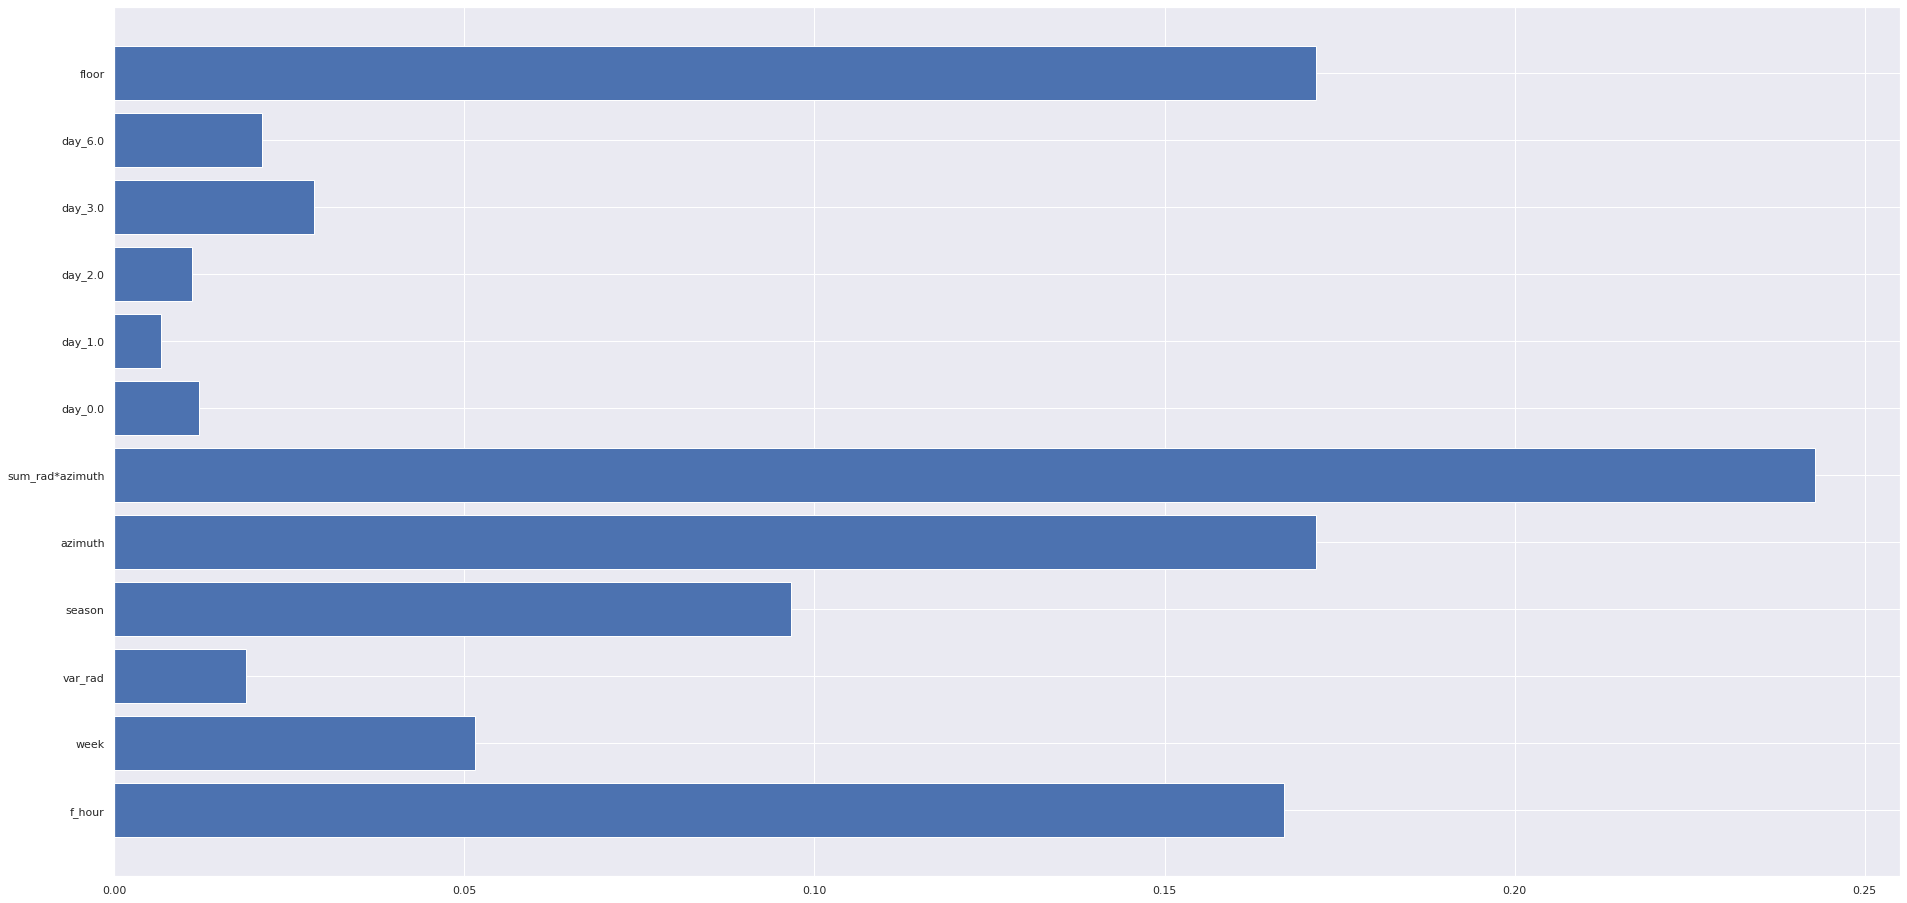

In [ ]:
plt.barh(X.columns, model.feature_importances_)
type(X)

## Model selection

In [ ]:
import itertools

N = 3
features = ['f_hour','week','season','azimuth','sum_rad*azimuth', 'floor']
length = len(features)

result = ['f_hour','week','season','azimuth','sum_rad*azimuth','floor']
for i in range(2, 3):
    result.extend(itertools.combinations(features, i))
# result = [list(r) if len(r)>1 else r for r in result]
result = [list(x) if i >= length else x for i,x in enumerate(result)]

result

['f_hour',
 'week',
 'season',
 'azimuth',
 'sum_rad*azimuth',
 'floor',
 ['f_hour', 'week'],
 ['f_hour', 'season'],
 ['f_hour', 'azimuth'],
 ['f_hour', 'sum_rad*azimuth'],
 ['f_hour', 'floor'],
 ['week', 'season'],
 ['week', 'azimuth'],
 ['week', 'sum_rad*azimuth'],
 ['week', 'floor'],
 ['season', 'azimuth'],
 ['season', 'sum_rad*azimuth'],
 ['season', 'floor'],
 ['azimuth', 'sum_rad*azimuth'],
 ['azimuth', 'floor'],
 ['sum_rad*azimuth', 'floor']]

In [ ]:
X

,f_hour,week,var_rad,season,azimuth,sum_rad*azimuth,day_0.0,day_1.0,day_2.0,day_3.0,day_6.0,floor
0,10.000,2.0,NaN,1.0,200.0,NaN,1,0,0,0,0,25.0
1,10.000,2.0,NaN,1.0,200.0,1.358953,1,0,0,0,0,25.0
2,10.000,2.0,0.000000e+00,1.0,200.0,2.717905,1,0,0,0,0,25.0
3,10.000,2.0,0.000000e+00,1.0,200.0,4.076858,1,0,0,0,0,25.0
4,10.000,2.0,0.000000e+00,1.0,200.0,5.435811,1,0,0,0,0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2303945,9.833,10.0,-5.998096e-15,2.0,285.0,17.574766,0,0,1,0,0,27.0
2303946,9.833,10.0,-5.998096e-15,2.0,285.0,17.574766,0,0,1,0,0,27.0
2303947,9.833,10.0,-5.998096e-15,2.0,285.0,17.574766,0,0,1,0,0,27.0
2303948,9.833,10.0,-5.998096e-15,2.0,285.0,17.574766,0,0,1,0,0,27.0


In [ ]:

result = result[6:]
list_df = {}
attributes.clear() 
for r in result:
    print(r)
    attributes = r
    x = DF_sum_rad5[r]
    # y = DF_sum_rad5['Manual_int_target']
    # print(X)
    # # split data into train and test sets
    seed = 7
    test_size = 0.2
    X_train, X_test, y_train, y_test = train_test_split(x, Y, test_size=test_size, random_state=seed)
    # display(X_train)
    # display(X_test)
    # display(y_train)
    # display(y_test)

    #Uriel - ratio of classes
    from collections import Counter
    counter = Counter(y_train)
    # estimate scale_pos_weight value
    class_ratio = counter[0] / counter[1]
    print(class_ratio)

    # fit model no training data
    # xgb.set_config(verbosity=2)
    model = XGBClassifier(scale_pos_weight=class_ratio,feature_selector='thrifty',top_k=0)
    model.fit(X_train, y_train)#, eval_metric = f1_eval)
   
   
    # make predictions for test data
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]


    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
   
   
    print(confusion_matrix(y_test,predictions))
    print(classification_report(y_test,predictions))
   
    print(type(attributes))
    attributes = set(attributes)
    print(type(attributes))


    #Detailed table
    list_df[attributes] = [accuracy, float("{:.3f}".format(list(classification_report(y_test,predictions,output_dict=True)['1'].values())[:-1][0])), float("{:.3f}".format(list(classification_report(y_test,predictions,output_dict=True)['1'].values())[:-1][1])), float("{:.3f}".format(list(classification_report(y_test,predictions,output_dict=True)['1'].values())[:-1][2]))]
    dff = pd.DataFrame.from_dict(list_df,orient='index')
dff = dff.rename(columns={0: "Accuracy", 1: "Precision",2: "Recall", 3: "F1"})
dff


NameError: ignored

In [ ]:
type(attributes)
# dff.sort_values(by ='F1' )

In [ ]:
import copy


import itertools
result = []
N = 3
features = ['f_hour','week','season','azimuth','sum_rad*azimuth','floor']
length = len(features)

# result = ['f_hour','week','season','azimuth','sum_rad*azimuth','floor']
for i in range(2, 4):
    result.extend(itertools.combinations(features, i))
# result = [list(r) if len(r)>1 else r for r in result]
#result = [list(x) if i >= length else x for i,x in enumerate(result)]
# result = result[6:]
result

In [ ]:

# result
# result = result[6:]

list_df = {}
# attributes.clear() 
for r in result:
  print(r)
  at = copy.deepcopy(r)
  x = DF_sum_rad5[list(r)]
  # y = DF_sum_rad5['Manual_int_target']
  display(x.shape)
  
  # display(Y.shape)


  # # split data into train and test sets
  seed = 7
  test_size = 0.2
  X_train, X_test, y_train, y_test = train_test_split(x, Y, test_size=test_size, random_state=seed)
  # display(X_train)
  # display(X_test)
  # display(y_train)
  # display(y_test)

  #Uriel - ratio of classes
  from collections import Counter
  counter = Counter(y_train)
  # estimate scale_pos_weight value
  class_ratio = counter[0] / counter[1]
  print(class_ratio)

  # fit model no training data
  # xgb.set_config(verbosity=2)
  model = XGBClassifier(scale_pos_weight=int(class_ratio),feature_selector='thrifty',top_k=0)
  model.fit(X_train, y_train)#, eval_metric = f1_eval)


  # make predictions for test data
  y_pred = model.predict(X_test)
  predictions = [round(value) for value in y_pred]


  # evaluate predictions
  accuracy = accuracy_score(y_test, predictions)
  print("Accuracy: %.2f%%" % (accuracy * 100.0))


  print(confusion_matrix(y_test,predictions))
  print(classification_report(y_test,predictions))

  # print(type(attributes))
  # #attributes = set(attributes)
  # print(type(attributes))


  #Detailed table
  list_df[at] = [accuracy, float("{:.3f}".format(list(classification_report(y_test,predictions,output_dict=True)['1'].values())[:-1][0]))
                          , float("{:.3f}".format(list(classification_report(y_test,predictions,output_dict=True)['1'].values())[:-1][1])),
                          float("{:.3f}".format(list(classification_report(y_test,predictions,output_dict=True)['1'].values())[:-1][2]))]
dff = pd.DataFrame.from_dict(list_df,orient='index')
dff = dff.rename(columns={0: "Accuracy", 1: "Precision",2: "Recall", 3: "F1"})
dff

In [ ]:
dff.sort_values(by =['F1','Precision', 'Recall'],ascending=False)

# Exploratory decision analysis

Time between opening to closing

In [ ]:
def shift_add(df, n):

# Calculate sum of corresponding values in 'change_in_auto' and 'manual_intervention' columns for different shift values
# n*10 is Maximum shift value in min

  delta_between_auto_cange_to_manual_change = pd.DataFrame()
  for i in range(1, n+1):
      result_col_name = f'{i}_min_since_auto'
      df[result_col_name] = df['change_in_auto'] + df['Manual_intervension_start'].shift(i).fillna(0)
      display(df[result_col_name].value_counts().fillna(0).loc[2])
      delta_between_auto_cange_to_manual_change.at[0,result_col_name] = df[result_col_name].value_counts().fillna(0).loc[2]
  histo = delta_between_auto_cange_to_manual_change

  return df, histo

new_df,histo  = shift_add(fixed_proccessed_df,5)
ax = histo.plot.bar()

In [ ]:
# delta_between_auto_cange_to_manual_change = data
# for i in range(1, 4):
#     result_col_name = f'result_shift_{i}'
#     delta_between_auto_cange_to_manual_change.append(fixed_proccessed_df[result_col_name].value_counts().loc[2])